Event Study: Cybersecurity Breaches Effects on Stock Price

<b>include a blurb here talking about our study. talk about why we pay attention to date of disclosure</b>

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

<h2>Data Collection</h2> 

We will be using the <a href= "https://wrds-www.wharton.upenn.edu/">WRDS</a> (Wharton Research Data Services) database to find financial analyst predictions on stock price using their <a href= "https://www.investopedia.com/terms/i/ibes.asp">IBES</a> dataset. The WRDS database is provided to all UMD staff and students for free, you can sign up for an account <a href="https://wrds-www.wharton.upenn.edu/register/">here</a>. When running this following section of code, you must supply your account's credentials. We recommend setting up a <a href = "https://matteocourthoud.github.io/post/wrds/"> pgpass</a> to help automate the process.

In [2]:
db = wrds.Connection()

Enter your WRDS username [gabri]:gnaval
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


We will be using the Audit Analytics February 2021 issue of cybersecurity databreaches. To get this dataset, we contacted the University of Maryland's Smith Business School, which provided this Excel file to us. <a href = "https://www.auditanalytics.com/">Audit Analytics</a> is an organization that tracks relevant business and financial data such as the information of a company cybersecurity breach. 

We will now load in the data by accessing the correct Excel sheet. 

In [3]:
# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')

Each row in this dataset represents a company's cybersecurity breach. The dataset contains useful information such as the company breached, date of public disclosure of the breach, and other varying information about the company and the type of cybersecurity breach performed. 

To clean the data, we need to drop all the rows that don't contain any company tickers. <a href ="https://www.wikiwand.com/en/Ticker_symbol">Tickers</a>, consisting of numbers and letters, are short abbreviations uniquely identifying a publicly traded company (Ex: Amazon is uniquely identified by their ticker, AMZN). If a row doesn't have a ticker symbol, then there may have been data corruption, human errors logging the data, or the company may not be publicly traded. Either way, we need to remove the rows. We also extract the relevant columns for our analysis (as shown in the table_columns array). Once this is all done, it leaves us with a dataset of 737 cybersecurity breaches on publicly traded companies.

In [ ]:
# Data Cleaning
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)
table_columns = ['Company name', 'Ticker', 'Date of Breach', 'Date Became Aware of Breach', 'Date of Disclosure',
                 'Number of Records', 'Type of Info', 'Information', 'Attack', 'Region', 'SIC Code']
aa_records_df = aa_records_df[aa_records_df.columns.intersection(table_columns)]

Now, let's try to find the monthly stock price of each of these firms following the disclosure of the breach.

Before we do that, we define a short helper function that will help us find the closest date in a set that corresponds to X months after the disclosure of a breach. We will make use of this utility in our main function for finding monthly stock prices.

In [ ]:
def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price X months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

With that out of the way, let's construct a function to obtain the monthly stock prices after the disclosure of the data breach. Let's break it down! 

Our function has two parameters: a row from our original breach dataframe and the number of months to get stock prices from. First, our function determines the range of dates to obtain monthly stock prices. Please note that our starting date is a day before the disclosure breach as to control for any fluctuations in stock price due to that disclosure. Following this, we leverage <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html">pandas_datareader</a>, an <a href="https://rapidapi.com/blog/api-glossary/api-wrapper/#:~:text=In%20that%20line%2C%20an%20API,to%20automate%20API%2Dreliant%20processes.">API wrapper</a> for various API's. Specifically, we will be using its <a href = "https://finance.yahoo.com/">YahooFinance</a> API functionality, which will provide us with a dataframe of stock prices (df) beginning at our start date and ending at our end date. We then traverse through this dataframe, using our nearest helper function, to obtain the monthly stock prices and return them as an array. 

If the YahooFinance API cannot find a company's stock price for whatever reason, it returns an array of np.nan's. Likewise, if 
no stock price is available for a month because it's missing or because that month's date lies in the future and hasn't occurred yet, then the array will be populated by np.nan's for those months.

Note: We record the <a href = "https://finance.zacks.com/significance-closing-price-stock-3007.html">closing</a> stock prices, meaning its the stock price at the end of a day. <br>
Note: The YahooFinance API has a limit of 2,000 requests per hour. As we only have 737 breaches, we won't be hitting that limit, but keep that in mind when using API's.

In [5]:
today = datetime.datetime.today().date()

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur 
    or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    start -= datetime.timedelta(days=1) 
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        lst = []
        for month in range(0, num_months + 1):
            if today <= (start + pd.DateOffset(months = month)).date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)

Let's run our function on each row in our dataset. We'll be finding the monthly stock prices spanning a year after the disclosure of the breach. 

Note: This section of code takes a while to run (20-30 minutes) because we will be making API requests, loading in data from a server, and performing operations on said data.

In [ ]:
lst = []
months_after = 12 #Toggle this value
col = []
# Set the column names for new dataframe
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

Following this, we can concatenate said data to our original dataframe.

In [ ]:
# Merge stock price after breach with original dataframe
stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')

We now have the actual stock prices. Let's move on to finding analyst predictions for these companies. 

We define the function below to find the analyst stock price predictions. It makes use of the <a href="https://www.investopedia.com/terms/i/ibes.asp">IBES</a> database in WRDS. The function takes all the financial analyst predictions within a month of the disclosure of the breach that forecast the company's stock price a year into the future. Since multiple financial analysts may make predictions, this function returns the median and mean of these predictions. If no predictions are found, the function returns np.nan's. 

Note: This function makes use of SQL, a programming language used to communicate with databases. Here are some helpful resources to get started learning about SQL: <a href = "https://www.codecademy.com/learn/learn-sql">CodeAcademy</a>, <a href = "https://www.khanacademy.org/computing/computer-programming/sql">KhanAcademy</a>

In [15]:
def analyst_stock_price(row):
    """
    Returns the median and mean of analyst stock price forecasts for a firm, where the forecasts are within a month after the beach. 
    These forecasts predict the stock price 12 months into the future.
    
    Parameters
        row - Dataframe row
        Input dataframe's row (used along with df.apply)
    Returns
        List of length 2. [median, mean]
    """
    date = pd.to_datetime(row['Date of Disclosure'])
    
    sql_query="""
    SELECT VALUE as stock_price
    FROM ibes.ptgdet
    WHERE OFTIC ='{}' AND CAST(HORIZON as int) = 12 AND ANNDATS BETWEEN '{}' and '{}'
    """.format(row['Ticker'], date, date + pd.DateOffset(months = 1))
    
    df = db.raw_sql(sql_query)
    
    if len(df.index) == 0:
        return [np.nan] * 2
    return [df['stock_price'].median(), df['stock_price'].mean()]
    

We can now run the function on each company to get the financial analyst forecasts.

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
lst = []
for index, row in stock_price_aa_records.iterrows():
    lst.append(analyst_stock_price(row))
    
# Merge stock price after breach with original dataframe
median_mean_df = pd.DataFrame(lst, columns = ['median stock forecast', 'mean stock forecast'])
stock_price_aa_records = pd.concat([stock_price_aa_records, median_mean_df], axis=1, join='inner')

Nice! We have now collected all the data to compare actual stock prices with financial analyst predicted stock prices. But before we do some Exploratory Data Analysis (EDA), we need to do...

<h2>Data Transformation and Management</h2> 

As it turns out, we might want to transform some of our data relating to stock prices because of innate variation between companies. 

To better understand this problem, consider this hypothetical: Suppose company A's and company B's stock price both double after a year. However, company A's initial stock was much smaller, say it started at \\$10 and became \\$20 per share, while company B's stock went from \\$100 to \\$200 per share. Their numerical growth are rather different, but their percent growth are the same. When comparing growth between companies, it makes more sense to compare percent growth since it will better control for the already established stock of that company (whether that be high or low). In a way, finding the percent growth is like standardizing each company's current stock price by their initial stock price.

For that reason, we need to be looking at percent stock price change for these companies, where the initial stock price corresponds to the stock price the day of the disclosure for the breach. The code below transforms the data to percent stock price change for the actual and predicted stock prices.

In [26]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1
    
t1 = stock_price_aa_records.apply(lambda row: (row['median stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)
t2 = stock_price_aa_records.apply(lambda row: (row['mean stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)

analysts_percent = pd.concat([stock_prices[12], pd.DataFrame(t1), pd.DataFrame(t2)], axis=1, join='inner')
analysts_percent.columns = ['Actual', 'Analyst Median', 'Analyst Mean']

<h2>Exploratory Data Analysis</h2>

To begin, let's make some boxplots and violin plots to get a better understanding of how actual stock prices change over time. We will be making use of the <a href="https://seaborn.pydata.org/index.html">seaborn</a> Python library. We also make use of <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html">melting</a> (more info <a href="http://www.jeannicholashould.com/tidy-data-in-python.html">here</a>).

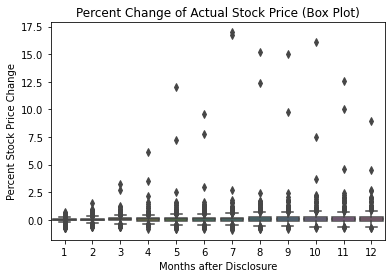

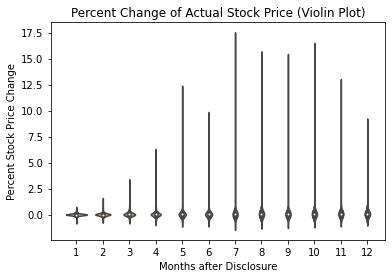

In [28]:
boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Percent Stock Price Change') 
boxplot.set_title("Percent Change of Actual Stock Price (Box Plot)")
plt.show()

ax = sns.violinplot(x='variable', y='value', data=pd.melt(stock_prices).dropna())

plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
ax.set_title("Percent Change of Actual Stock Price (Violin Plot)")
ax.plot()
plt.show()

Well...these plots don't really help but why? It seems that there are some major outliers that are making it hard to see how the percent change of actual stock price shifts over time. We have two options here: <a name="two_options"></a>
1. Remove the outliers and re-plot the data.
2. Find a better metric to represent these distributions over time.

Let's opt to do the second option. There are other metrics to represent these distributions, namely seeing how the "middle" of these distributions change over time. We can define the "middle" of each of these distributions to be the mean or median stock price percent change over time. 

Let's take the naive approach of plotting the mean over time.

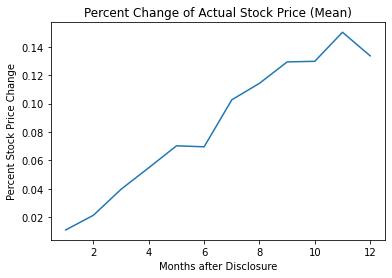

In [29]:
plt.plot(np.arange(1, 13), stock_prices.mean())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Mean)")
plt.show()

It seems like the mean trends upwards over time. This is to say that over time, after public disclosure of a breach, the stock price of companies tend to still trend upwards. It seems that public disclosure of a breach might not have long-term consequences to a company's stock price. 

But wait! Let's not forget:
> <i>"There are three kinds of lies: lies, damned lies, and <b>statistics</b>."</i>
> \- Mark Twain

Means are only good representations of the "middle" of a distribution given that there are <a href = "https://statistics.laerd.com/statistical-guides/measures-central-tendency-mean-mode-median.php#:~:text=When%20not%20to%20use%20the%20mean">no influential outliers and no skewness</a>. A better way of representing the "middle" would be to use the median, which is less affected by outliers and skewness. Let's plot the medians.

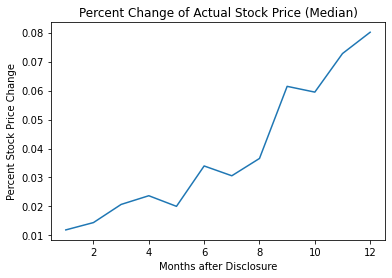

In [30]:
plt.plot(np.arange(1, 13), stock_prices.median())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Median)")
plt.show()

It seems like when we plot the median over time, the same trend occurs, <b>but</b> it's important to note that the percent stock price percent change values are not as large as the plot of means. Even more important is that the trend no longer seems exactly linear. It seems like the stock price grows slowly at the beginning and then gradually increases later on. This could be representative of a company recovering from the public disclosure of the breach at the start (which causes less stock gains) but after a while the company's growth goes back to normal. We'll look more into the details of this when we perform the event study.

Another way of representing the "middle" is to take the <a href="https://www.investopedia.com/terms/t/trimmed_mean.asp">trimmed mean</a> to get rid of outliers. Below, we took the 5% trimmed means and plotted them. It looks to have the similar trends and observations as the plot of medians.

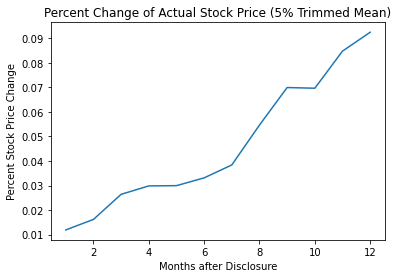

In [31]:
# Let's take 5% trimmed mean (get rid of some outliers)
trimmed_means = []
for x in range(1, months_after + 1):
    trimmed_means.append(stats.trim_mean(stock_prices[x].dropna(), 0.05))
plt.plot(np.arange(1, 13), trimmed_means)
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (5% Trimmed Mean)")
plt.show()    

Let's now compare the actual versus financial analyst predictions of the stock price a year after the public disclosure of a cybersecurity breach. We will do this through a violin plot.

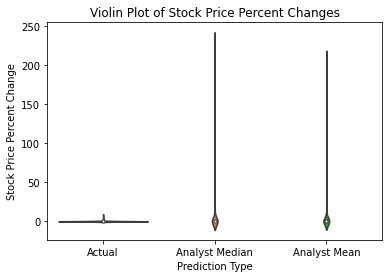

In [33]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Actual', 'Analyst Median', 'Analyst Mean']]).dropna())
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change')
violinplot.set_title("Violin Plot of Stock Price Percent Changes")
plt.show()

Once again, there appears to be some outliers for these distributions, specifically for financial analyst predictions. As mentioned [before](#two_options), there are two options for handling these outliers. We don't really want to use a new metric like the "middle" because we want to compare the actual distributions, so we will instead opt for option one and remove the outliers. 

We will be removing the outliers for the financial analyst median and mean predictions. To remove the outliers, we need some rule to label something as an outlier. There are different methods for classifying outliers, but we opt to abide by the <a href="https://www.wikiwand.com/en/68%E2%80%9395%E2%80%9399.7_rule">three-sigma rule</a>, which states that nearly all values are taken to lie within three <a href= "https://www.wikiwand.com/en/Standard_deviation">standard deviations</a> of the mean. If a point were to be beyond three standard deviations from the mean, then we will classify that point as an outlier and remove it from the distribution. The following creates distributions without these outliers.

In [34]:
z_scores = stats.zscore(analysts_percent['Analyst Median'].dropna())

abs_z_scores = np.abs(z_scores)
medians_no_outliers = analysts_percent['Analyst Median'].dropna()[abs_z_scores < 3]

z_scores = stats.zscore(analysts_percent['Analyst Mean'].dropna())

abs_z_scores = np.abs(z_scores)
means_no_outliers = analysts_percent['Analyst Mean'].dropna()[abs_z_scores < 3]

Let's now create a new violin plot without the outliers.

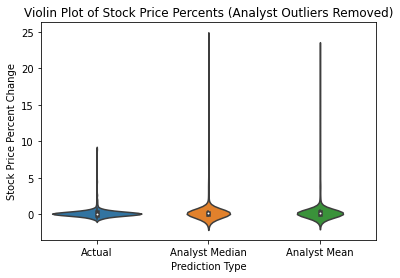

In [36]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([analysts_percent['Actual'],medians_no_outliers, means_no_outliers], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percents (Analyst Outliers Removed)")
plt.show()

This violin plot is way more legible than the previous. It seems from this violin plot that the financial analyst predictions tend to vary more than the actual stock prices. It also hints that financial analysts tend to overestimate the actual stock price of these companies. A better method of visualizing these differences is to look at the residuals of these stock prices, where the residual is the actual minus the predicted stock price percent change.

The following code will compute the residuals for each prediction type and plot them. Note that for this part, the outlier financial analyst predictions have been kept.

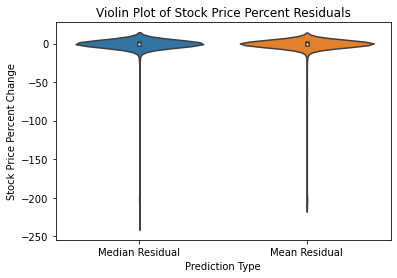

In [38]:
analysts_percent['Median Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Median"], axis =1)
analysts_percent['Mean Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Mean"], axis =1)

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Median Residual', 'Mean Residual']]))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

It seems the distribution of these different residuals appear very similar. It also appears that these distributions center around 0 but are skewed towards the negative end. For this to happen, it means that financial analyst predictions are greater than the actual stock prices. 

For a better look, here's a display the summary statistics for each residual distribution. I would like to note that our initial sample of cybersecurity breaches was 737, but it has now shrunk down to a set of 474 breaches. This could either be due to the Yahoo Finance API not containing stock prices for certain companies, IBES not having predictions for smaller companies, or a year hasn't elapsed since the public disclosure of the cybersecurity breach.

In [39]:
print(analysts_percent['Median Residual'].describe())
print()
print(analysts_percent['Mean Residual'].describe())

count    476.000000
mean      -1.758415
std       17.179386
min     -231.820000
25%       -0.278717
50%       -0.033483
75%        0.189021
max        4.721649
Name: Median Residual, dtype: float64

count    476.000000
mean      -1.703157
std       16.497254
min     -208.660000
25%       -0.285764
50%       -0.028402
75%        0.193967
max        4.721649
Name: Mean Residual, dtype: float64


It does seem that financial analysts overestimate the actual stock prices for these firms that had recently issued public disclosures of cybersecurity breaches. We need a to perform a more scientific/mathematical study to conclude this. This takes us to our next section...

<h2>Hypothesis Testing</h2>

We want to perform a statistical test to confirm our findings that the financial analysts overestimate the actual stock price. Specifically, we want a test that proves that these residuals we've found skew towards negative. In other words, we want to prove that the mean ($\mu$) of the distribution of residuals is negative and that these results are statistically significant, meaning there is little to no doubt that the mean is 0.

The best test for this situation would be a 1-sample t-test, specifically a <a href= "https://www.statisticssolutions.com/manova-analysis-paired-sample-t-test/#:~:text=The%20paired%20sample%20t%2Dtest,resulting%20in%20pairs%20of%20observations.">paired sample t-test</a>. To get an understanding of how this test works, we need to understand what a <a href = "https://support.minitab.com/en-us/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/basics/null-and-alternative-hypotheses">null and alternative hypothesis</a> are. The null hypothesis states that a population parameter is equal to a hypothesized value. The alternative hypothesis states that a population parameter is different from the hypothesized value posited in the null hypothesis. These two hypotheses are mutually exclusive (if one is true, the other is false). In this case, our hypotheses are:

- Null Hypothesis: 		$\mu = 0$
- Alternative Hypothesis:	$\mu < 0$

The null hypothesis roughly translates to the mean of the distribution of residuals is equal to 0, meaning that we expect no difference between the actual and predicted stock prices. The alternative hypothesis roughly translates to the mean of the distribution of residuals is less than 0, meaning that the predicted stock prices tend to be greater than the actual stock prices. 

In this statistical test, we begin with assuming the null hypothesis is true. We then study our sample dataset (through statistical methods) to see if given the null hypothesis is true, the sample dataset could reasonably occur. If our data could not reasonably happen under the premise of the null hypothesis, then we reject the null hypothesis and assume it's false. Since the null hypothesis is false in these circumstances, we would have to accept the alternative hypothesis as true. In the case that the data is not significantly opposed to the premise of the null hypothesis, we fail to reject the null hypothesis - meaning we have no evidence to believe its contrary. This is the essence of most statistical hypothesis testing. For a more through explanation, click <a href= "https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/">here</a>.

Before we can perform this test, we need to meet certain prerequisites. We need to meet the three assumptions: independence of observations, approximately normal distributions, and no major outliers. We can reasonably assume independence of observations since one company’s residual does not affect another’s. From the violin plot, it seems that the distribution is approximately normal and to meet the assumption of no major outliers, we will remove outliers from the dataset when performing the test. Depicted below is a violin plot of the residuals with major outliers removed.

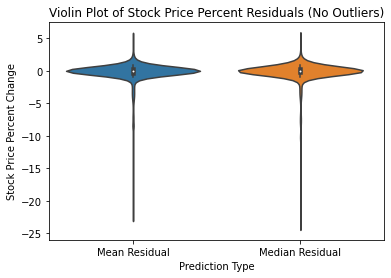

In [43]:
z_scores = stats.zscore(analysts_percent['Median Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_median = analysts_percent['Median Residual'].dropna()[abs_z_scores < 3]

z_scores = stats.zscore(analysts_percent['Mean Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_mean = analysts_percent['Mean Residual'].dropna()[abs_z_scores < 3]

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([no_outliers_mean, no_outliers_median], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') 
violinplot.set_title("Violin Plot of Stock Price Percent Residuals (No Outliers)")
plt.show()

We also have to establish a <a href="https://blog.minitab.com/en/adventures-in-statistics-2/understanding-hypothesis-tests-significance-levels-alpha-and-p-values-in-statistics">significance level</a> before running the test. We choose a significance level of 5%, meaning if a sample has a less than 5% chance of occurring given the null hypothesis, then we will reject the null hypothesis and accept the alternative.

The following code will output the p-values for the median and mean residual hypothesis tests respectively. Outliers have been removed for this test.

Note: We are performing a <a href = "https://www.statisticssolutions.com/should-you-use-a-one-tailed-test-or-a-two-tailed-test-for-your-data-analysis/#:~:text=This%20is%20because%20a%20two,groups%20in%20a%20specific%20direction.">one-tailed test</a>, so we will halve the p-values.

In [44]:
print("Median residual p-value: %s" % (stats.ttest_1samp(a=no_outliers_median, popmean=0).pvalue/2))
print("Mean residual p-value: %s" % (stats.ttest_1samp(a=no_outliers_mean, popmean=0).pvalue/2))

Median residual p-value: 0.0013188772935642584
Mean residual p-value: 0.0005504523294492413


These p-values are extremely small, smaller than our significance level of 5%. Since these p-values are extremely small, the chance that these samples could have occurred given the null hypothesis are nearly impossible, so we reject the null hypothesis and accept that alternative hypothesis that $\mu$ < 0. We can now conclude that financial analysts tend to overestimate the stock price of a company after the public disclosure of a cybersecurity breach.

<h3>Aside: What if we hadn't removed the outliers for the residuals?</h3>

Suppose we hadn't removed the residuals and still ran the t-tests as is. We would have gotten these p-values:

In [45]:
print("Median residual p-value: %s" % (stats.ttest_1samp(a=analysts_percent['Median Residual'].dropna(), popmean=0).pvalue/2))
print("Mean residual p-value: %s" % (stats.ttest_1samp(analysts_percent['Mean Residual'].dropna(), popmean=0).pvalue/2))

Median residual p-value: 0.013002146782097813
Mean residual p-value: 0.012376210232805244


We would have still rejected the null hypothesis and accepted the alternative, but we would have to say that a major caveat was that we don't meet all the assumptions to run this test.

<h2>Event-Study</h2>

<h2>Conclusion</h2>